# Matching volunteers to recipients
## Task
Given:
- scv **tables of parameters** (what's requested, location, etc) coded simply in 0 and 1 (as NO and YES)
- **table of importance** of weighted parameters (what's requested is more important then location), from 0 to 10
    - 0: do not take this silimarity into account; 
    - 10: most important

Make a pairing for volunteers and recipients baised on they weighted similarity 

## Data
collected from volunteer and recipient questionnaires performed in Google Forms

Volunteer Questionnaire:
https://forms.gle/8sRETZybcqzSrQTU6

Recipient Questionnaire:
https://forms.gle/Z1w9FtEvphtDm8547

<table>
  <td>  
      <img src="figures/VQv.jpg">
  </td>  
  <td>
      <img src="figures/RQv.jpg">
  </td>
</table>

After filling, answers can be downloaded as CSV file:
<table>
  <tr>  
      <img src="figures/VolT.jpg">
  </tr>  
  <tr>
      <img src="figures/ResT.jpg">
  </tr>
</table>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Load csv files of questionnaire resposes
volunteers = pd.read_csv ('Volunteer questionnaire (Responses) - Form Responses 1.csv')
recipients = pd.read_csv ('Recipient Questionnaire (Responses) - Form Responses 1.csv')
N_volunteers = volunteers.shape[0]
N_recipients = recipients.shape[0]
volunteers.head()

,Timestamp,How would you like to help?,Location,Would you help any of people listed below first?,Language of communication,Can you take such requests:,Contact Name,e-mail,phone
0,4/13/2020 17:45:21,"Buy and deliver groceries, I will pay for gro...","Southwest Portland, Beaverton, Hillsboro","Tested COVID-19 positive, Feeling sick,hes not...","English, Russian","Emmergency, Urgent, Not urgent",Vera,vera.tsintsadze@gmail.com,503-407-****
1,4/13/2020 21:20:09,"Buy and deliver groceries, recipient will refu...","North Portland, East Portland, Northeast Portl...","Tested COVID-19 positive, Feeling sick,hes not...","English, Spanish","Emmergency, Urgent, Not urgent",Superman,superman@powers.org,NaN
2,4/13/2020 21:21:16,Donate money to households in need,"North Portland, East Portland, Northeast Portl...",NaN,"English, Viethnamise",NaN,Goodman,goodman@goodman.com,NaN


*ParameterImportance.csv* file has the list of parameters, their meaning in both volunteer and recipient questionnairs, their initial value and the importanse.
Importance of a parameter means a contribution of this parameter in the sililary coefficients, i.e. it's weight.

In [4]:
Importance = pd.read_csv ('ParameterImportance.csv', sep='\t')
Importance.head()

,Variable_name,Question_volunteer,Answer_volunteer,Question_recipient,Answer_recipient,ImportanceCoef,Innitial_values
0,OR_bdpg,How would you like to help?,"Buy and deliver groceries, I will pay for gro...",What kind of help do you need?,"Buy and deliver groceries, volunteer will need...",10,0
1,OR_bdg,How would you like to help?,"Buy and deliver groceries, recipient will refu...",What kind of help do you need?,"Buy and deliver groceries, I will refund cost",10,1
2,OR_bdpm,How would you like to help?,"Buy and deliver out-of-counter medicine, I wil...",What kind of help do you need?,"Buy and deliver out-of-counter medicine, volun...",10,0
3,OR_bdm,How would you like to help?,"Buy and deliver out-of-counter medicine, recip...",What kind of help do you need?,"Buy and deliver out-of-counter medicine, I wil...",10,0
4,OR_bs,How would you like to help?,Babyseating,What kind of help do you need?,Babyseating,10,0


In [5]:
List_of_vars = Importance['Variable_name'].tolist()
N_vars = len(List_of_vars)
###Initiation of matricies V and R
V = pd.DataFrame(data = np.zeros([N_volunteers, N_vars]), columns = List_of_vars)
R = pd.DataFrame(data = np.zeros([N_recipients, N_vars]), columns = List_of_vars)
for var in List_of_vars:
    indx = Importance.index[Importance['Variable_name']==var].tolist()[0]
    V[var] = Importance.loc[indx,'Innitial_values']
    R[var] = Importance.loc[indx,'Innitial_values']

Now we need to transform responses to questions from *volunteers* and *recipients* DataFrames into 1s and 0s of V andR dataframes

In [6]:
#volunteers
for var in List_of_vars:
    for indx_V in V.index:                                  #iterating throw the variables and volunteers
        indx_imp = Importance.index[Importance['Variable_name']==var].tolist()[0]
        Ques = Importance.iloc[indx_imp]['Question_volunteer'] #find the str name of the question in Importance dataframe
        Ans = Importance.iloc[indx_imp]['Answer_volunteer']    #answer
        try:
            if Ans in volunteers.loc[indx_V][Ques]:  #is the Ans corresponding to the variable name in the long string of volunteers?
            #put 1 in the V dataframe
                V.loc[indx_V, var] = 1
            else:
                V.loc[indx_V, var] = 0
        except:
            None     
#same for recipients
for var in List_of_vars:
    for indx_R in R.index:                                  #iterating throw the variables and volunteers
        indx_imp = Importance.index[Importance['Variable_name']==var].tolist()[0]
        Ques = Importance.iloc[indx_imp]['Question_recipient'] #find the str name of the question in Importance dataframe
        Ans = Importance.iloc[indx_imp]['Answer_recipient']    #answer
        try:
            if Ans in recipients.loc[indx_R][Ques]:  #is the Ans corresponding to the variable name in the long string of volunteers?
            #put 1 in the V dataframe
                R.loc[indx_R, var] = 1
            else:
                R.loc[indx_R, var] = 0
        except:
            None

In [7]:
print(V.shape, R.shape)

(3, 29) (4, 29)


In [8]:
#Get numpy arrays from V and R for calculating similarity
npV = V.to_numpy()
npR = R.to_numpy()
print(npV.shape, npR.shape)

(3, 29) (4, 29)


In [9]:
#Weights for making decision
ImportCoef = Importance['ImportanceCoef'].values

### Cosine Similarity

K(X, Y) = <X, Y> / (||X||*||Y||); normalized dot product of X and Y
<img src="figures/index.png">

RETURN algo.similarity.cosine([3,8,7,5,2,9], [10,8,6,6,4,5]) AS similarity
<img src="figures/cosine-similarity2.png">

In [11]:
#weighted cosine similarity from scratch
def weighted_sim_coef (A,B,I):  #for 1D np.arrays of the same length
    dev = np.sqrt(np.sum(np.square(A)))*np.sqrt(np.sum(np.square(B)))
    return np.sum(A*B*I)/dev        

In [12]:
#Similarity of first recipient to first volunteer
weighted_sim_coef (npV[0,:],npV[0,:],ImportCoef)

7.071428571428571

In [13]:
#Similarity of first recipient to all volunteers
Sim_for_first_rec = []
for v in range(N_volunteers):
    Sim_for_first_rec.append(weighted_sim_coef (npR[0,:],npV[v,:],ImportCoef))
print ('Similarity of first recipient to all volunteers', Sim_for_first_rec)
print('Biggest similarity volunteer', np.argmax(Sim_for_first_rec))

Similarity of first recipient to all volunteers [5.3452248382484875, 3.5634832254989917, 2.519763153394848]
Biggest similarity volunteer 0


In [14]:
#Similarity of first recipient to all volunteers
Sim_for_all = np.zeros((N_recipients, N_volunteers))
for r in range(N_recipients):
    for v in range(N_volunteers):
        Sim_for_all[r,v] = (weighted_sim_coef (npR[r,:],npV[v,:],ImportCoef))
Sim_for_all

array([[5.34522484, 3.56348323, 2.51976315],
       [2.1514115 , 2.03188864, 1.35224681],
       [4.16619045, 2.62315695, 3.70970413],
       [1.06904497, 1.46993683, 2.0788046 ]])

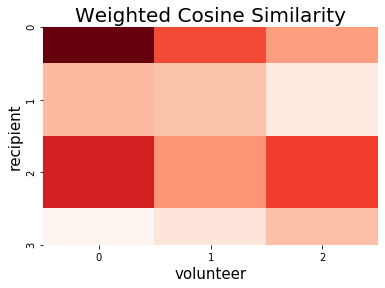

In [15]:
#Visualization: darker red - more similar are recipient-volunteer pair
sns.heatmap(Sim_for_all, cmap="Reds", cbar=False)
plt.title('Weighted Cosine Similarity', fontsize=20)
plt.xlabel('volunteer', fontsize=15)
plt.ylabel('recipient', fontsize=15)
plt.show()